# Task 1: Classification

1. define a Neural Network
2. define optimization procedure on FashionMNIST
3. train classifier on training set
4. evaluate model on test set
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from utils import NoisyFashionMNIST
from sklearn.metrics import precision_recall_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Dataset: 
Downloads the FashionMNIST dataset in your local directory ./data  
The following code shows how to access and visualize the data.

In [2]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


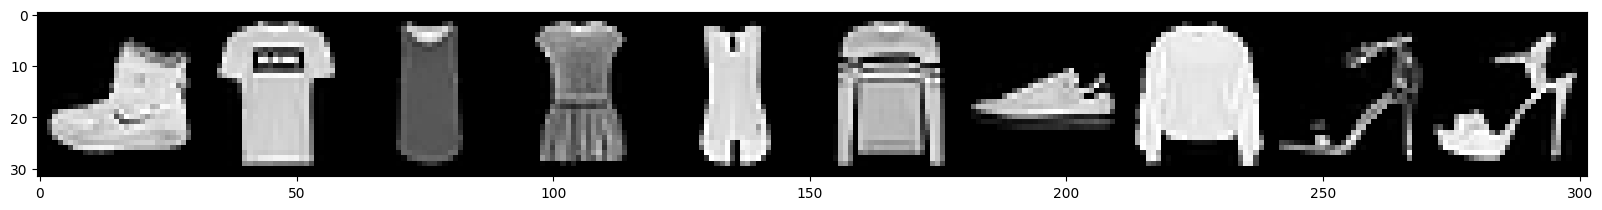

In [3]:
x = [train_dataset[i][0] for i in range(10)]
labels = [idx_to_class[train_dataset[i][1]] for i in range(10)]
print(labels)

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

## Model

In [4]:
# From Traning-Example Notebook
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

## Training

In [5]:
?F.nll_loss

Signature:
F.nll_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    size_average: Optional[bool] = None,
    ignore_index: int = -100,
    reduce: Optional[bool] = None,
    reduction: str = 'mean',
) -> torch.Tensor
Docstring:
Compute the negative log likelihood loss.

See :class:`~torch.nn.NLLLoss` for details.

Args:
    input: :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
        in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K \geq 1`
        in the case of K-dimensional loss. `input` is expected to be log-probabilities.
    target: :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
        or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
        K-dimensional loss.
    weight (Tensor, optional): a manual rescaling weight given to each
        class. If given, has to be a Tensor of size `C`
    size_average (bool, optional): Deprecated (see :attr

In [6]:
def train(model, device, loader, optimizer, loss_fn, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        # Debug:
        # print(target.shape)
        # print(data.shape)

        optimizer.zero_grad()
        output = model(data)
        # print(output.shape)
        loss = loss_fn(output, target)
        # print("Real class:", target.shape)
        # print("Predicted class:", output.argmax(dim=1, keepdim=True).squeeze())
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()), end='\r')


def test(model, device, loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # print(output.shape)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(loader.dataset),
    100. * correct / len(loader.dataset)), end='\r')

In [7]:
model = Net()
model.to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
?torch.optim.lr_scheduler.StepLR

Init signature:
torch.optim.lr_scheduler.StepLR(
    optimizer: torch.optim.optimizer.Optimizer,
    step_size: int,
    gamma: float = 0.1,
    last_epoch: int = -1,
)
Docstring:     
Decays the learning rate of each parameter group by gamma every step_size epochs.

Notice that such decay can happen simultaneously with other changes to the learning rate
from outside this scheduler. When last_epoch=-1, sets initial lr as lr.

Args:
    optimizer (Optimizer): Wrapped optimizer.
    step_size (int): Period of learning rate decay.
    gamma (float): Multiplicative factor of learning rate decay.
        Default: 0.1.
    last_epoch (int): The index of last epoch. Default: -1.

Example:
    >>> # xdoctest: +SKIP
    >>> # Assuming optimizer uses lr = 0.05 for all groups
    >>> # lr = 0.05     if epoch < 30
    >>> # lr = 0.005    if 30 <= epoch < 60
    >>> # lr = 0.0005   if 60 <= epoch < 90
    >>> # ...
    >>> scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    >>> for epoch in 

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

for epoch in range(1, 11):
    train(model, device, train_loader, optimizer, loss_fn, epoch)
    test(model, device, test_loader, loss_fn)
    scheduler.step()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 37.831295
Test set: Average loss: 0.3349, Accuracy: 8778/10000 (88%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 15.878497
Test set: Average loss: 0.2804, Accuracy: 8961/10000 (90%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 28.931368
Test set: Average loss: 0.2615, Accuracy: 9040/10000 (90%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 22.723404
Test set: Average loss: 0.2438, Accuracy: 9097/10000 (91%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 21.588448
Test set: Average loss: 0.2346, Accuracy: 9166/10000 (92%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 6.0141003
Test set: Average loss: 0.2212, Accuracy: 9218/10000 (92%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 15.002153
Test set: Average loss: 0.2192, Accuracy: 9235/10000 (92%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 16.841898
Test set: Average loss: 0.2165, Accuracy: 9240/10000 (92%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 11.638474
Test set: Average loss: 0.2168, Accuracy: 9238/10000 (92%)
Train Epoc

## Evaluation
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

### Confusion Matrix in shape 10x10 foir each class

In [10]:
type(test_dataset)

torchvision.datasets.mnist.FashionMNIST

In [11]:
dir(torchvision.datasets.mnist.FashionMNIST)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_check_legacy_exist',
 '_format_transform_repr',
 '_is_protocol',
 '_load_data',
 '_load_legacy_data',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'download',
 'extra_repr',
 'mirrors',
 'processed_folder',
 'raw_folder',
 'resources',
 'test_data',
 'test_file',
 'test_labels',
 'train_data',
 'train_labels',
 'training_file']

In [12]:
test_dataset.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

Text(0, 0.5, 'True Label')

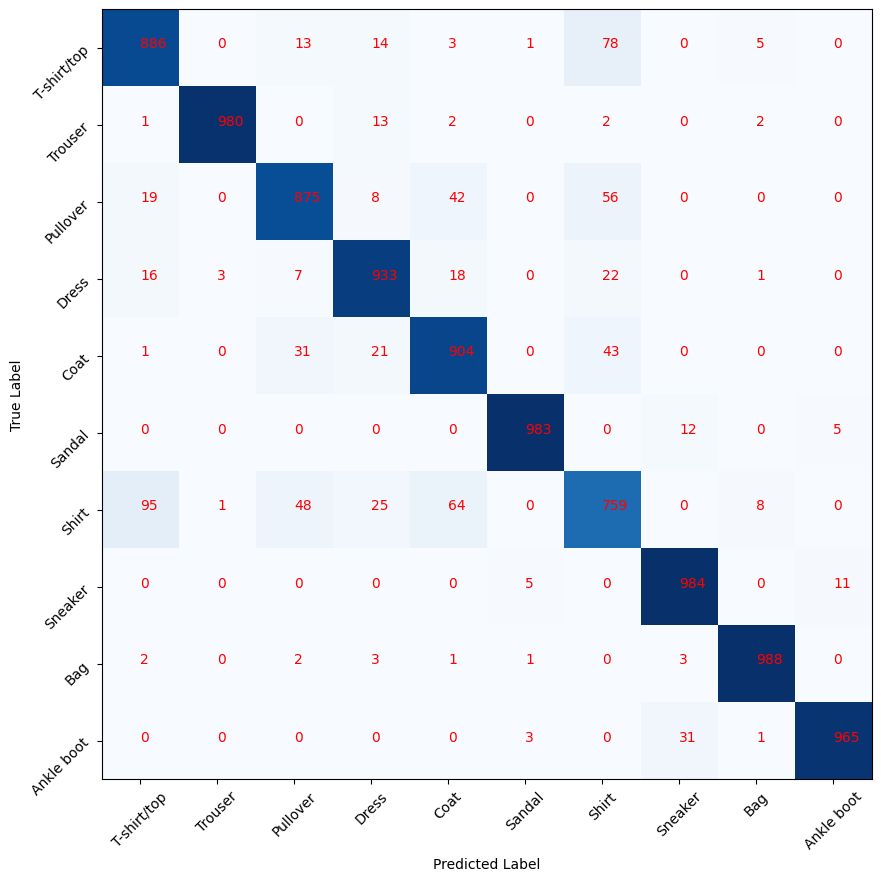

In [13]:
confusion_matrix = torch.zeros(10, 10)
# Y: True Label
# X: Predicted Label

model.eval()
# Iterate over all images in test_set
for data, target in test_dataset:
    data = data.to(device)
    # print(data.shape)
    output = model(data.unsqueeze(0))
    pred = output.argmax(dim=1, keepdim=True)
    # print(f"target: {target} has prediction {pred}")
    confusion_matrix[target][pred.to("cpu")] += 1

# Plot matrix
plt.figure(figsize=(10,10))
plt.xticks(range(10), [idx_to_class[i] for i in range(10)], rotation=45)
plt.yticks(range(10), [idx_to_class[i] for i in range(10)], rotation=45)
for i in range(10):
    for j in range(10):
        plt.text(j,i, int(confusion_matrix[i][j]), color="red")

plt.imshow(confusion_matrix, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

## Accuracy, Precision, Recall and F1 using the maximum response

In [14]:
true_positive = torch.zeros(10)     # TP
true_negative = torch.zeros(10)     # TN
false_positive = torch.zeros(10)    # FP
false_negative = torch.zeros(10)    # FN 

model.eval()
model.to(device)
for data, target in test_dataset:
    data = data.to(device)
    out = model(data.unsqueeze(0))
    pred = out.argmax(dim=1, keepdims= True)
    if pred == target:
        true_positive[target] += 1          # TP
        # True Negatives
        for i in range(10):
            if i != target:
                true_negative[i] += 1       # TN
    else:
        false_negative[target] += 1         # FN
        false_positive[pred.to("cpu")] += 1 # FP

# Accuracy: correct classifications/total classifications   OR  (TP+TN)/(TP+TN+FP+FN) 
accuracy_matrix = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Precision:  correct actual positives/ everthing classified as positive:  TP/(TP+FP)
precision_matrix = true_positive/(true_positive + false_positive)

# Recall: correct actual positives/ all actual positives : TP/(TP+FN)
recall_matric = true_positive/(true_positive + false_negative)

# F1 Score: 2* (Precision*Recall)/(Precision+Recall)   OR  # 2*TP/(2*TP + FP + FN)
f1_matrix = 2 * true_positive / (2*true_positive + false_positive + false_negative)
f1_matrix_2 = 2* (precision_matrix * recall_matric) / (precision_matrix + recall_matric)

for i in range(10):
    print(idx_to_class[i])
    print(f"  Accuracy for: {round(float(accuracy_matrix[i]*100), 2)}%")
    print(f"  Precision for: {round(float(precision_matrix[i]*100), 2)}%")
    print(f"  Recall for: {round(float(recall_matric[i]*100), 2)}%")
    print(f"  F1 Score: {round(float(f1_matrix[i]*100), 2)}%\n")
    # print(f"F1 Score : {f1_matrix_2[i]}%")

T-shirt/top
  Accuracy for: 97.39%
  Precision for: 86.86%
  Recall for: 88.6%
  F1 Score: 87.72%

Trouser
  Accuracy for: 99.74%
  Precision for: 99.59%
  Recall for: 98.0%
  F1 Score: 98.79%

Pullover
  Accuracy for: 97.62%
  Precision for: 89.65%
  Recall for: 87.5%
  F1 Score: 88.56%

Dress
  Accuracy for: 98.39%
  Precision for: 91.74%
  Recall for: 93.3%
  F1 Score: 92.51%

Coat
  Accuracy for: 97.62%
  Precision for: 87.43%
  Recall for: 90.4%
  F1 Score: 88.89%

Sandal
  Accuracy for: 99.71%
  Precision for: 98.99%
  Recall for: 98.3%
  F1 Score: 98.65%

Shirt
  Accuracy for: 95.44%
  Precision for: 79.06%
  Recall for: 75.9%
  F1 Score: 77.45%

Sneaker
  Accuracy for: 99.33%
  Precision for: 95.53%
  Recall for: 98.4%
  F1 Score: 96.95%

Bag
  Accuracy for: 99.69%
  Precision for: 98.31%
  Recall for: 98.8%
  F1 Score: 98.55%

Ankle boot
  Accuracy for: 99.45%
  Precision for: 98.37%
  Recall for: 96.5%
  F1 Score: 97.43%



## visualize Precision-Recall curve for different classes 

In [15]:
?precision_recall_curve

Signature:
precision_recall_curve(
    y_true,
    y_score,
    *,
    pos_label=None,
    sample_weight=None,
    drop_intermediate=False,
)
Docstring:
Compute precision-recall pairs for different probability thresholds.

Note: this implementation is restricted to the binary classification task.

The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
true positives and ``fp`` the number of false positives. The precision is
intuitively the ability of the classifier not to label as positive a sample
that is negative.

The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
true positives and ``fn`` the number of false negatives. The recall is
intuitively the ability of the classifier to find all the positive samples.

The last precision and recall values are 1. and 0. respectively and do not
have a corresponding threshold. This ensures that the graph starts on the
y axis.

The first precision and recall values are precision=class balance and recall=

Text(0.5, 1.0, "Precision-Recall Curve for classes: ['T-shirt/top', 'Dress', 'Sandal', 'Bag']")

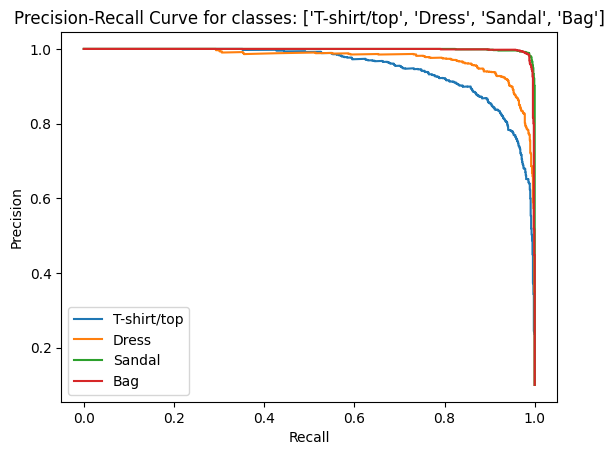

In [16]:
indices = [0,3,5,8]

for i in indices:
    y_true = (test_dataset.targets == i)
    y_scores = []

    model.eval()
    for data, target in test_dataset:
        data = data.to(device)
        out = model(data.unsqueeze(0))
        i_score = out[0][i].item()
        # print(i_score)
        y_scores.append(i_score)
    
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, label=f"{idx_to_class[i]}")

plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve for classes: {[idx_to_class[i] for i in indices]}")

## visualize example images with predicted classes

(0, 0, 0, 0, 0)


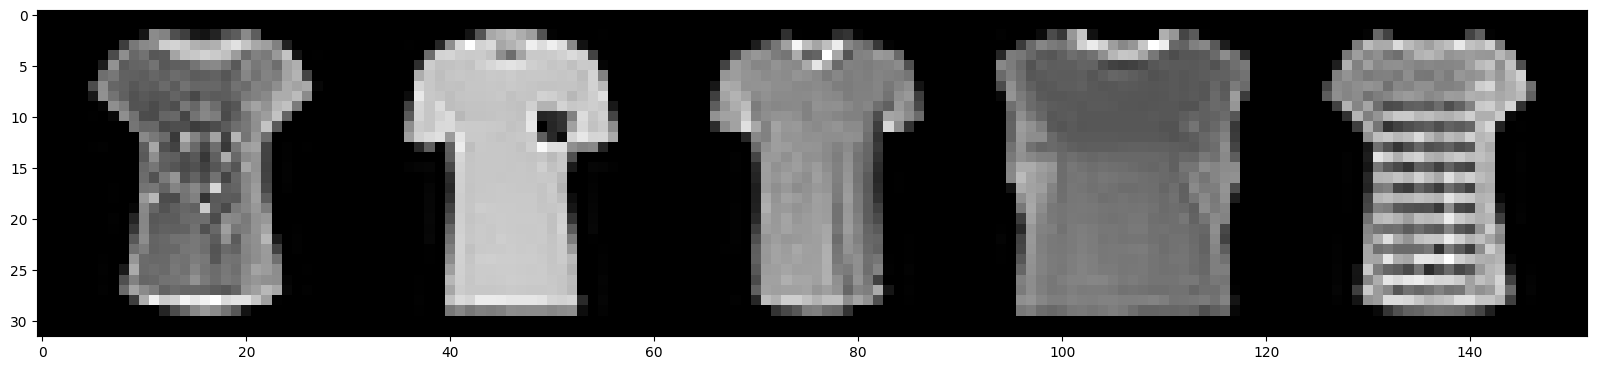

In [17]:
import random 

def visualize_examples(class_idx, amount, dataset = test_dataset):
    predictions = []
    for data, target in test_dataset:
        data = data.to(device)
        out = model(data.unsqueeze(0))
        pred = out.argmax(dim=1, keepdim=True)
        predictions.append(pred.item())

    # Indices with same class
    random_indices = torch.where(torch.tensor(predictions) == class_idx)[0].tolist()
    indices = random.sample(random_indices, amount)

    # From "Training-Example.ipynb"
    x,y = zip(*[dataset[i] for i in indices])
    x = torch.stack(x)

    grid_img = torchvision.utils.make_grid(x, nrow=amount)
    plt.figure(figsize=(20,5))
    plt.imshow(grid_img.permute(1, 2, 0))
    print(y)

visualize_examples(class_idx = 0, amount = 5)

# Task 2: Image Denoising
1. define a Neural Network
2. define optimization procedure on NoisyFashionMNIST
3. train denoising model
4. Evaluate model

## Dataset
Random augmentations are added to the original dataset.

In [18]:
train_dataset_noisy = NoisyFashionMNIST("./data", True)
test_dataset_noisy = NoisyFashionMNIST("./data", False)

In [19]:
test_loader_noisy = torch.utils.data.DataLoader(test_dataset_noisy, batch_size=64, shuffle=False)

In [20]:
train_dataset_noisy.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37030065..1.3379501].


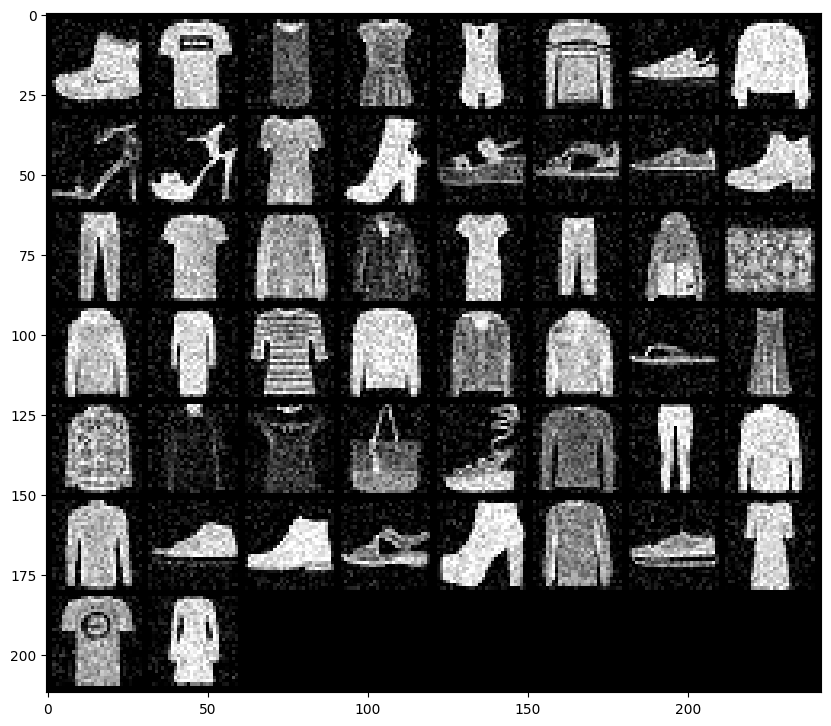

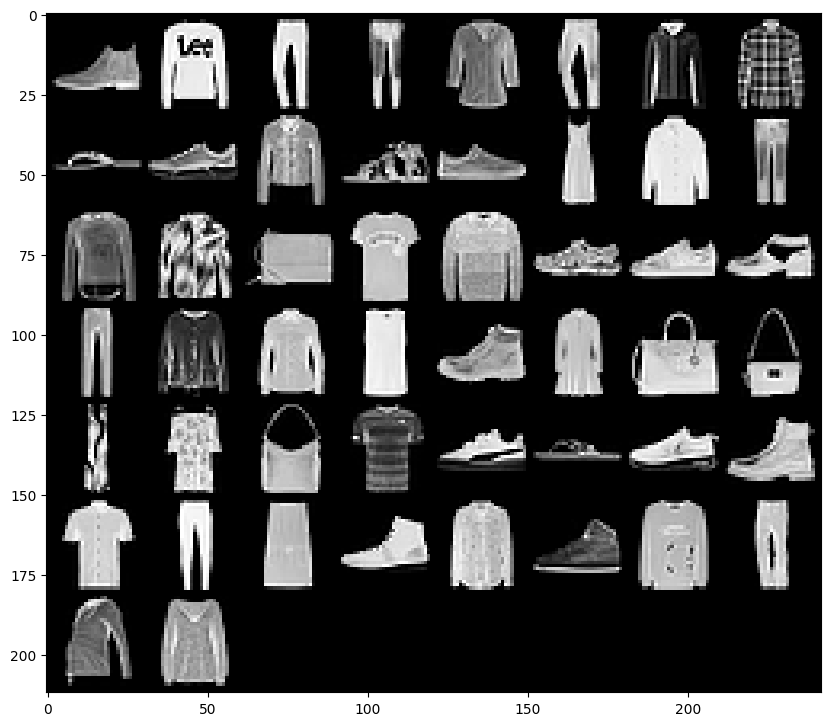

In [21]:
x = [train_dataset_noisy[i][0] for i in range(50)]
y = [test_dataset_noisy[i][1] for i in range(50)]

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(x))
plt.show()

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(y))
plt.show()

## Classifier

### Model

In [22]:
model_noisy = Net()
model_noisy.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Train

There is a problem with the `NoisyFashionMNIST` dataset from `utils.py`. It never returns the correct labels but instead `noisy_img, img`. Therefore a new combined dataset is introducted for training which combines the noisy images with the labels.

In [23]:
from torch.utils.data import Dataset

class NoisyWithLabels(Dataset):
    def __init__(self, noisy_dataset):
        self.noisy = noisy_dataset
        self.clean = noisy_dataset.dataset

    def __len__(self):
        return len(self.noisy)

    def __getitem__(self, idx):
        noisy_img, original_img = self.noisy[idx]  
        label = self.clean[idx][1]                   # int label from FashionMNIST
        return torch.tensor(noisy_img), torch.tensor(label)

wrapped_train = NoisyWithLabels(train_dataset_noisy)
wrapped_test  = NoisyWithLabels(test_dataset_noisy)

wrapped_train_loader = torch.utils.data.DataLoader(wrapped_train, batch_size=64, shuffle=True)
wrapped_test_loader  = torch.utils.data.DataLoader(wrapped_test,  batch_size=64, shuffle=False)

# Print first 10 of dataset
x = [wrapped_train[i][0] for i in range(10)]
labels = [wrapped_train[i][1] for i in range(10)]
print(labels)

# get from real dataset first 10
x_clean = [train_dataset[i][0] for i in range(10)]
labels_clean = [train_dataset[i][1] for i in range(10)]
print(labels_clean)

[tensor(9), tensor(0), tensor(0), tensor(3), tensor(0), tensor(2), tensor(7), tensor(2), tensor(5), tensor(5)]
[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


C:\Users\Jean\AppData\Local\Temp\ipykernel_36184\358494295.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_img), torch.tensor(label)


In [24]:
print("Normal FashionMNIST:")
for data, target in test_loader:
    print(f"Data shape: {data.shape}") 
    print(f"Target shape: {target.shape}")  
    break

print("\nNoisyFashionMNIST:")
for noisy_data, original_data in test_loader_noisy:
    print(f"Noisy Data shape: {noisy_data.shape}") 
    print(f"Original Data shape: {original_data.shape}")
    break

Normal FashionMNIST:
Data shape: torch.Size([64, 1, 28, 28])
Target shape: torch.Size([64])

NoisyFashionMNIST:
Noisy Data shape: torch.Size([64, 1, 28, 28])
Original Data shape: torch.Size([64, 1, 28, 28])


In [25]:
model_noisy = Net().to(device)

In [26]:
optimizer = torch.optim.Adam(model_noisy.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

for epoch in range(1, 11):
    train(model_noisy, device, wrapped_train_loader, optimizer, loss_fn, epoch)
    test(model_noisy, device, wrapped_test_loader, loss_fn)
    scheduler.step()

C:\Users\Jean\AppData\Local\Temp\ipykernel_36184\358494295.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_img), torch.tensor(label)


Train Epoch: 1 [59520/60000 (99%)]	Loss: 17.083872
Test set: Average loss: 0.3795, Accuracy: 8620/10000 (86%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 24.337051
Test set: Average loss: 0.3244, Accuracy: 8808/10000 (88%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 14.695333
Test set: Average loss: 0.3089, Accuracy: 8852/10000 (89%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 22.035055
Test set: Average loss: 0.2902, Accuracy: 8952/10000 (90%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 22.019827
Test set: Average loss: 0.2834, Accuracy: 8971/10000 (90%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 20.912827
Test set: Average loss: 0.2729, Accuracy: 9013/10000 (90%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 16.788185
Test set: Average loss: 0.2699, Accuracy: 9011/10000 (90%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 17.645311
Test set: Average loss: 0.2675, Accuracy: 9048/10000 (90%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 13.314420
Test set: Average loss: 0.2661, Accuracy: 9037/10000 (90%)
Train Epoc

## Denoising Model

### Model

In [27]:
class DenoisingNet(nn.Module):
    def __init__(self):
        super(DenoisingNet, self).__init__()
        # Encoder (Down)
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)  # Output: [32, 28, 28]
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)  # Output: [64, 28, 28]

        # Decoder (Up)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # Output: [32, 28, 28]
        self.deconv2 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1)  # Output: [1, 28, 28]

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        # print(f"After conv1: {x.shape}")
        x = F.relu(x)
        x = self.conv2(x)
        # print(f"After conv2: {x.shape}")
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print(f"After max_pool2d: {x.shape}")
        # x = self.dropout1(x)

        # Decoder
        x = self.deconv1(x)
        # print(f"After deconv1: {x.shape}")
        x = F.relu(x)
        x = self.deconv2(x)
        # print(f"After deconv2: {x.shape}")
        output = torch.sigmoid(x)  # For pixel values in [0, 1]
        return output

In [28]:
dummy_input = torch.randn(1, 1, 28, 28)
denoising_test = DenoisingNet().to(device)
denoising_test(dummy_input.to(device))

tensor([[[[0.4735, 0.5121, 0.4591, 0.5287, 0.4531, 0.4902, 0.4653, 0.5034,
           0.4346, 0.5132, 0.4507, 0.4933, 0.4571, 0.4734, 0.4636, 0.4667,
           0.4045, 0.5341, 0.4824, 0.5124, 0.4670, 0.4735, 0.4316, 0.5185,
           0.4662, 0.5109, 0.4475, 0.5143],
          [0.4818, 0.4918, 0.5275, 0.4863, 0.5118, 0.5411, 0.5758, 0.4838,
           0.5105, 0.4982, 0.5638, 0.4835, 0.5181, 0.5296, 0.5370, 0.5531,
           0.6160, 0.4277, 0.5499, 0.4932, 0.5637, 0.4489, 0.5846, 0.5070,
           0.5837, 0.4871, 0.5280, 0.5153],
          [0.4656, 0.4817, 0.4522, 0.5387, 0.5013, 0.4616, 0.4532, 0.4950,
           0.4577, 0.5202, 0.4675, 0.4621, 0.4310, 0.4898, 0.4698, 0.5089,
           0.4433, 0.5227, 0.4251, 0.5021, 0.4197, 0.5234, 0.4147, 0.5246,
           0.4104, 0.5208, 0.4452, 0.5235],
          [0.4631, 0.4843, 0.5721, 0.4932, 0.5590, 0.5087, 0.5498, 0.5621,
           0.5456, 0.4947, 0.5347, 0.4569, 0.5234, 0.4548, 0.5266, 0.4246,
           0.5751, 0.4400, 0.5868, 0.4431, 

### Training

In [29]:
train_loader_denoise = torch.utils.data.DataLoader(train_dataset_noisy, batch_size=64, shuffle=True)
test_loader_denoise = torch.utils.data.DataLoader(test_dataset_noisy, batch_size=64, shuffle=False)

In [30]:
model_denoise = DenoisingNet().to(device)
optimizer = torch.optim.Adam(model_denoise.parameters(), lr=0.001)
loss_fn = nn.MSELoss(reduction='sum')

for epoch in range(1, 11):
    train(model_denoise, device, train_loader_denoise, optimizer, loss_fn, epoch)
    print("\n")
    # test(model_denoise, device, test_loader_denoise, loss_fn)

Train Epoch: 1 [59520/60000 (99%)]	Loss: 152.486176

Train Epoch: 2 [59520/60000 (99%)]	Loss: 146.194244

Train Epoch: 3 [59520/60000 (99%)]	Loss: 128.078049

Train Epoch: 4 [59520/60000 (99%)]	Loss: 124.248421

Train Epoch: 5 [59520/60000 (99%)]	Loss: 122.243027

Train Epoch: 6 [59520/60000 (99%)]	Loss: 112.616104

Train Epoch: 7 [59520/60000 (99%)]	Loss: 130.389435

Train Epoch: 8 [59520/60000 (99%)]	Loss: 117.330177

Train Epoch: 9 [59520/60000 (99%)]	Loss: 107.125740

Train Epoch: 10 [59520/60000 (99%)]	Loss: 117.119537



In [31]:
def visualize_denoising_examples(amount, model, dataset=train_dataset_noisy):
    indices = random.sample(range(len(dataset)), amount)

    noisy_images, original_images = zip(*[dataset[idx] for idx in indices])
    with torch.no_grad():
        denoised_images = [model(noisy_img.unsqueeze(0).to(device)) for noisy_img in noisy_images]

    # Plot the images
    plt.figure(figsize=(20, 10))
    for i in range(amount):
        # Original images (row 1)
        plt.subplot(3, amount, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=14)

        # Noisy images (row 2)
        plt.subplot(3, amount, amount + i + 1)
        plt.imshow(noisy_images[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Noisy", fontsize=14)

        # Denoised images (row 3)
        plt.subplot(3, amount, 2 * amount + i + 1)
        plt.imshow(denoised_images[i].squeeze().to("cpu"), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Denoised", fontsize=14)

    plt.tight_layout()
    plt.show()

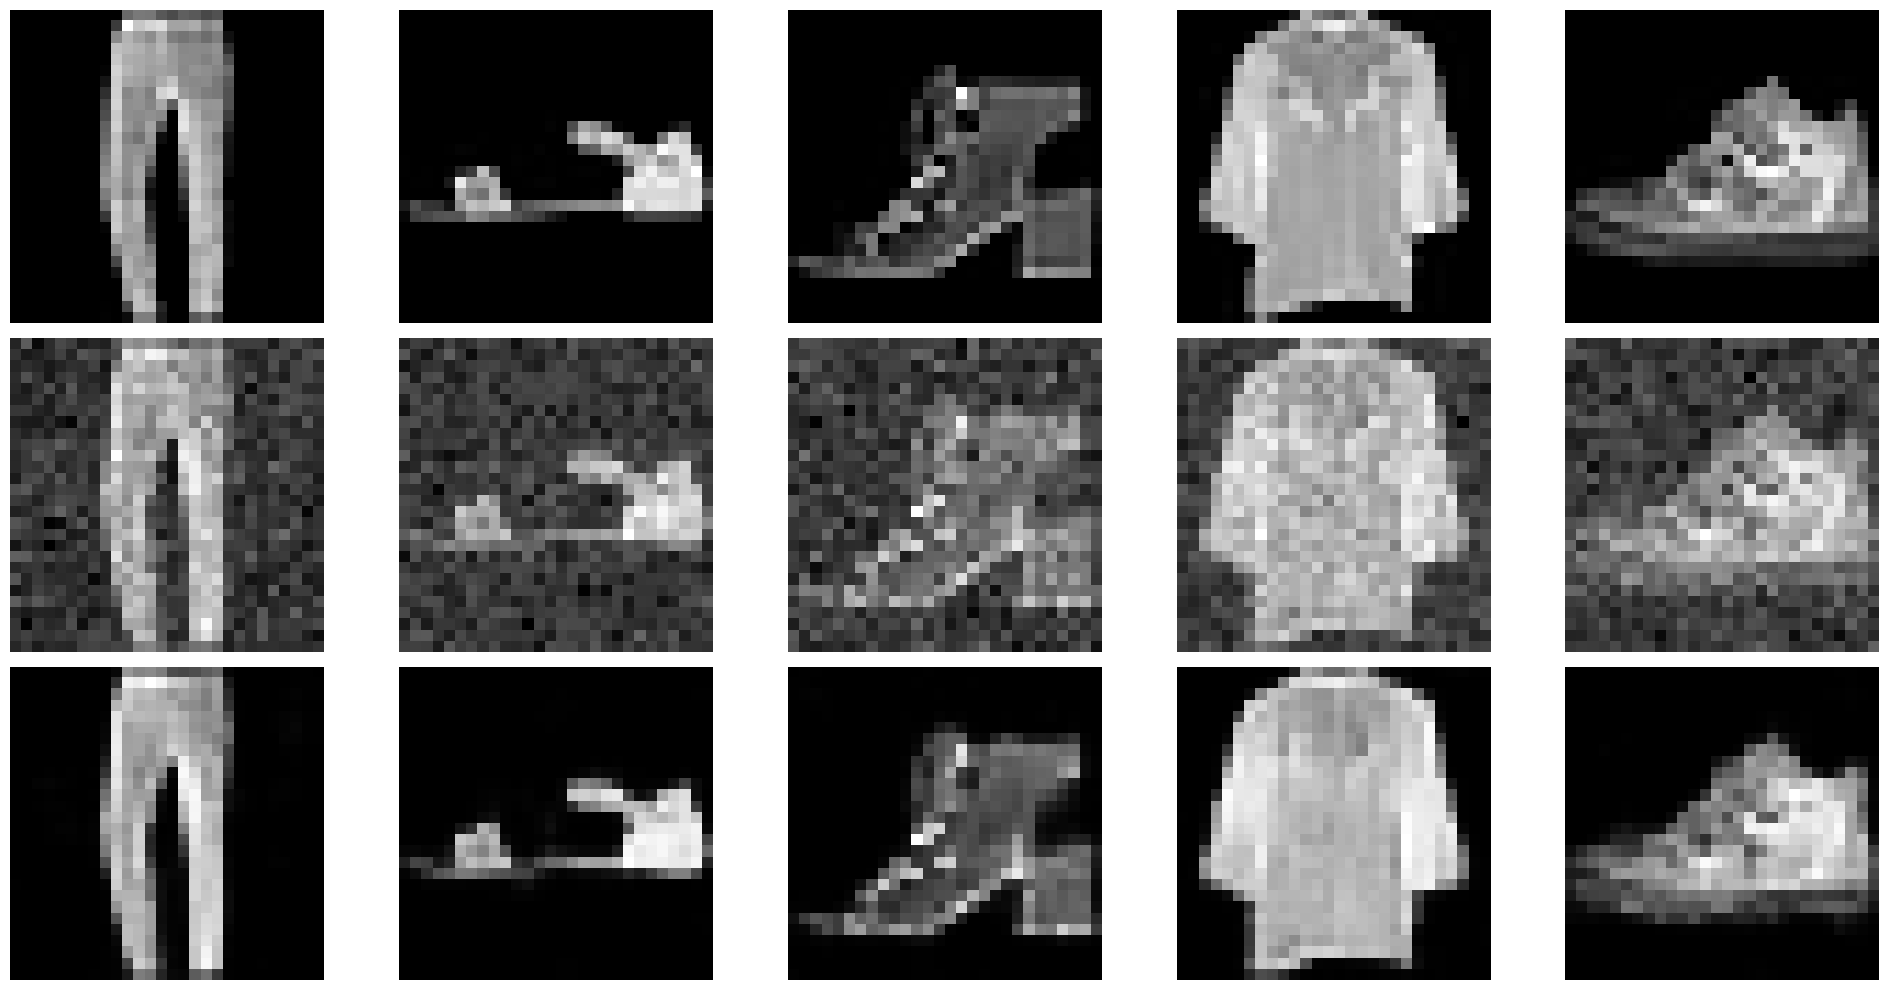

In [32]:
visualize_denoising_examples(amount=5, model=model_denoise, dataset=train_dataset_noisy)

# Task 3: Model Selection

Conduct at least **3 experiments** for **each** of the previous tasks and document them (i.e. at least 6 experiments).  
Evaluate the effect of different parameters on the classification and denoising tasks.  
Conduct the following experiments:
- Evaluate the effect of residual connections
- Evaluate the effect of the depth(number of layers)/width (number of channels or number of neurons) of the network  
- Evaluate the effect of Batch normalization

## Optional experiments:
- How does the loss function affect denoising? Alternative loss functions: MSE, MAE, SSIM?
- How does Dropout affect the performance?
- Use different downsampling/upsampling layers, e.g.pooling, strided convolution, transposed convolution, etc.  
- Feel free to explore more variations of your model and training.

In [33]:
train_loader_classification = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader_classification = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


## Experiment 1: Residual Connections (Skip Conn)

In [34]:
class skipcon(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(skipcon, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1) # padding requried else dim mismatch
         
        # match dimensions if stride or channels change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            print(f"Shortcut with stride {stride} and in_channels {in_channels} != out_channels {out_channels}")
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        skipped = self.shortcut(x) # 'x' in F(x) + x

        out = self.conv(x)
        
        out += skipped
        return out

### For the Classification Model 
It makes most sense to place residual connections around `conv1` and `conv2`.

In [35]:
class NetWithResidual(nn.Module):
    def __init__(self):
        super(NetWithResidual, self).__init__()
        self.skipcon1 = skipcon(in_channels=1, out_channels=32, stride=1)
        self.skipcon2 = skipcon(in_channels=32, out_channels=64, stride=1)
        
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.skipcon1(x)
        x = F.relu(x)
        x = self.skipcon2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [36]:
model_skipconn = NetWithResidual().to(device)

Shortcut with stride 1 and in_channels 1 != out_channels 32
Shortcut with stride 1 and in_channels 32 != out_channels 64


In [37]:
dummy_input = torch.randn(1, 1, 28, 28)

print(model(dummy_input.to(device)).shape)
print(model_skipconn(dummy_input.to(device)).shape)

torch.Size([1, 10])
torch.Size([1, 10])


In [38]:
optimizer_skipconn = torch.optim.Adam(model_skipconn.parameters(), lr=0.001)
scheduler_skipconn = torch.optim.lr_scheduler.StepLR(optimizer_skipconn, step_size=5, gamma=0.1)
loss_fn_classification = nn.CrossEntropyLoss(reduction='sum')

for epoch in range(1, 11):
    train(model_skipconn, device, train_loader_classification, optimizer_skipconn, loss_fn_classification, epoch)
    test(model_skipconn, device, test_loader_classification, loss_fn_classification)
    scheduler_skipconn.step()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 17.520901
Test set: Average loss: 0.3411, Accuracy: 8752/10000 (88%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 22.433104
Test set: Average loss: 0.3092, Accuracy: 8880/10000 (89%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 23.153088
Test set: Average loss: 0.2822, Accuracy: 8973/10000 (90%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 13.232941
Test set: Average loss: 0.2532, Accuracy: 9064/10000 (91%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 12.586752
Test set: Average loss: 0.2697, Accuracy: 9014/10000 (90%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 13.200518
Test set: Average loss: 0.2295, Accuracy: 9181/10000 (92%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 17.959152
Test set: Average loss: 0.2254, Accuracy: 9188/10000 (92%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 8.1024267
Test set: Average loss: 0.2232, Accuracy: 9224/10000 (92%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 4.3642231
Test set: Average loss: 0.2222, Accuracy: 9226/10000 (92%)
Train Epoc

In [39]:
true_positive = torch.zeros(10)     # TP
true_negative = torch.zeros(10)     # TN
false_positive = torch.zeros(10)    # FP
false_negative = torch.zeros(10)    # FN 

model_skipconn.eval()
model_skipconn.to(device)
for data, target in test_dataset:
    data = data.to(device)
    out = model_skipconn(data.unsqueeze(0))
    pred = out.argmax(dim=1, keepdims= True)
    if pred == target:
        true_positive[target] += 1          # TP
        # True Negatives
        for i in range(10):
            if i != target:
                true_negative[i] += 1       # TN
    else:
        false_negative[target] += 1         # FN
        false_positive[pred.to("cpu")] += 1 # FP

# Accuracy: correct classifications/total classifications   OR  (TP+TN)/(TP+TN+FP+FN) 
accuracy_matrix_skipconn = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Precision:  correct actual positives/ everthing classified as positive:  TP/(TP+FP)
precision_matrix_skipconn = true_positive/(true_positive + false_positive)

# Recall: correct actual positives/ all actual positives : TP/(TP+FN)
recall_matric_skipconn = true_positive/(true_positive + false_negative)

# F1 Score: 2* (Precision*Recall)/(Precision+Recall)   OR  # 2*TP/(2*TP + FP + FN)
f1_matrix_skipconn = 2 * true_positive / (2*true_positive + false_positive + false_negative)
f1_matrix_2_skipconn = 2* (precision_matrix_skipconn * recall_matric_skipconn) / (precision_matrix_skipconn + recall_matric_skipconn)

for i in range(10):
    print(idx_to_class[i])
    print(f"  Accuracy for: {round(float(accuracy_matrix_skipconn[i]*100), 2)}%")
    print(f"  Precision for: {round(float(precision_matrix_skipconn[i]*100), 2)}%")
    print(f"  Recall for: {round(float(recall_matric_skipconn[i]*100), 2)}%")
    print(f"  F1 Score: {round(float(f1_matrix_skipconn[i]*100), 2)}%\n")
    # print(f"F1 Score : {f1_matrix_2[i]}%")

T-shirt/top
  Accuracy for: 97.43%
  Precision for: 87.57%
  Recall for: 88.1%
  F1 Score: 87.84%

Trouser
  Accuracy for: 99.74%
  Precision for: 99.59%
  Recall for: 98.0%
  F1 Score: 98.79%

Pullover
  Accuracy for: 97.38%
  Precision for: 87.52%
  Recall for: 87.7%
  F1 Score: 87.61%

Dress
  Accuracy for: 98.3%
  Precision for: 91.02%
  Recall for: 93.2%
  F1 Score: 92.09%

Coat
  Accuracy for: 97.36%
  Precision for: 85.99%
  Recall for: 89.6%
  F1 Score: 87.76%

Sandal
  Accuracy for: 99.71%
  Precision for: 98.7%
  Recall for: 98.6%
  F1 Score: 98.65%

Shirt
  Accuracy for: 95.38%
  Precision for: 79.57%
  Recall for: 74.4%
  F1 Score: 76.9%

Sneaker
  Accuracy for: 99.4%
  Precision for: 96.92%
  Recall for: 97.5%
  F1 Score: 97.21%

Bag
  Accuracy for: 99.69%
  Precision for: 98.31%
  Recall for: 98.8%
  F1 Score: 98.55%

Ankle boot
  Accuracy for: 99.45%
  Precision for: 97.59%
  Recall for: 97.3%
  F1 Score: 97.45%



### For the Denoising Model

In [40]:
class DenoisingNetWithResidual(nn.Module):
    def __init__(self):
        super(DenoisingNetWithResidual, self).__init__()
        # Encoder (Down)
        self.skipcon1 = skipcon(in_channels=1, out_channels=32, stride=1)  # Output: [32, 28, 28]
        self.skipcon2 = skipcon(32, 64, stride=1)   # Output: [64, 28, 28]

        # Decoder (Up)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # Output: [32, 28, 28]
        self.deconv2 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1)  # Output: [1, 28, 28]

    def forward(self, x):
        # Encoder
        x = self.skipcon1(x)
        # print(f"After conv1: {x.shape}")
        x = F.relu(x)
        x = self.skipcon2(x)
        # print(f"After conv2: {x.shape}")
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print(f"After max_pool2d: {x.shape}")
        # x = self.dropout1(x)

        # Decoder
        x = self.deconv1(x)
        # print(f"After deconv1: {x.shape}")
        x = F.relu(x)
        x = self.deconv2(x)
        # print(f"After deconv2: {x.shape}")
        output = torch.sigmoid(x)  # For pixel values in [0, 1]
        return output

In [41]:
dummy_input_denoise = torch.randn(1, 1, 28, 28)
# Create an instance of the new model
denoising_model_res = DenoisingNetWithResidual()
print( denoising_model_res(dummy_input_denoise).shape)

Shortcut with stride 1 and in_channels 1 != out_channels 32
Shortcut with stride 1 and in_channels 32 != out_channels 64
torch.Size([1, 1, 28, 28])


In [42]:
model_denoise_skipcon = DenoisingNetWithResidual().to(device)
optimizer_skipconn = torch.optim.Adam(model_denoise_skipcon.parameters(), lr=0.001)
loss_fn_denoise = nn.MSELoss(reduction='sum')

for epoch in range(1, 11):
    train(model_denoise_skipcon, device, train_loader_denoise, optimizer_skipconn, loss_fn, epoch)
    print("\n")
    # test(model_denoise, device, test_loader_denoise, loss_fn)

Shortcut with stride 1 and in_channels 1 != out_channels 32
Shortcut with stride 1 and in_channels 32 != out_channels 64
Train Epoch: 1 [59520/60000 (99%)]	Loss: 132.685486

Train Epoch: 2 [59520/60000 (99%)]	Loss: 137.178116

Train Epoch: 3 [59520/60000 (99%)]	Loss: 126.671707

Train Epoch: 4 [59520/60000 (99%)]	Loss: 114.217804

Train Epoch: 5 [59520/60000 (99%)]	Loss: 117.457687

Train Epoch: 6 [59520/60000 (99%)]	Loss: 106.824150

Train Epoch: 7 [59520/60000 (99%)]	Loss: 100.058060

Train Epoch: 8 [59520/60000 (99%)]	Loss: 106.980682

Train Epoch: 9 [59520/60000 (99%)]	Loss: 116.145859

Train Epoch: 10 [59520/60000 (99%)]	Loss: 108.700409



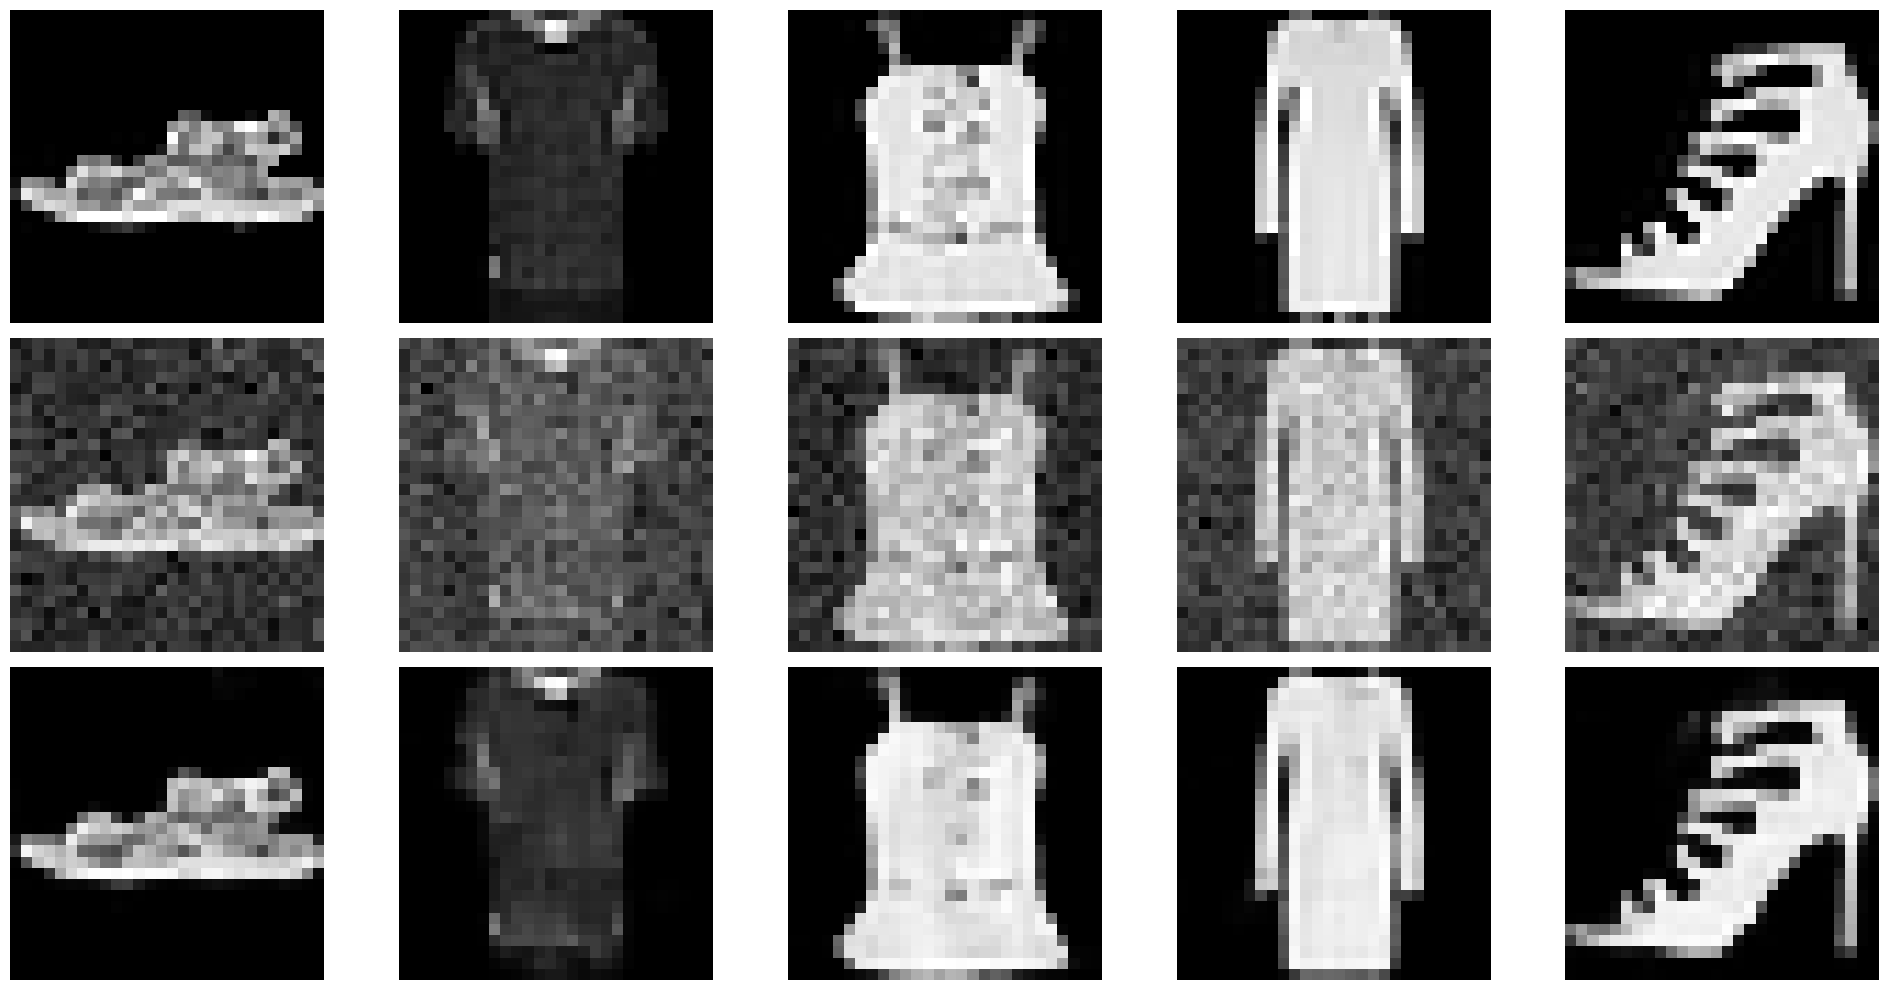

In [43]:
visualize_denoising_examples(amount=5, model=model_denoise_skipcon, dataset=train_dataset_noisy)

### Observation
The score and visual result are very similar with no significant improvement. This could be due to the fact that the reference model is very shallow.

## Experiment 2: Depth

### For Classification Model

In [59]:
class Net_Deeper(nn.Module):
    def __init__(self):
        super(Net_Deeper, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(25600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [60]:
model_deeper = Net_Deeper().to(device)
optimizer_deeper = torch.optim.Adam(model_deeper.parameters(), lr=0.001)
scheduler_deeper = torch.optim.lr_scheduler.StepLR(optimizer_deeper, step_size=5, gamma=0.1)

for epoch in range(1, 11):
    train(model_deeper, device, train_loader_classification, optimizer_deeper, loss_fn_classification, epoch)
    test(model_deeper, device, test_loader_classification, loss_fn_classification)
    scheduler_deeper.step()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 26.832378
Test set: Average loss: 0.3450, Accuracy: 8697/10000 (87%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 28.043657
Test set: Average loss: 0.2860, Accuracy: 8964/10000 (90%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 21.125534
Test set: Average loss: 0.2736, Accuracy: 9023/10000 (90%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 12.147954
Test set: Average loss: 0.2456, Accuracy: 9126/10000 (91%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 20.987885
Test set: Average loss: 0.2404, Accuracy: 9129/10000 (91%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 8.5103387
Test set: Average loss: 0.2136, Accuracy: 9244/10000 (92%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 14.066006
Test set: Average loss: 0.2107, Accuracy: 9248/10000 (92%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 11.493786
Test set: Average loss: 0.2114, Accuracy: 9267/10000 (93%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 13.250478
Test set: Average loss: 0.2121, Accuracy: 9263/10000 (93%)
Train Epoc

In [62]:
true_positive = torch.zeros(10)     # TP
true_negative = torch.zeros(10)     # TN
false_positive = torch.zeros(10)    # FP
false_negative = torch.zeros(10)    # FN 

model_deeper.eval()
model_deeper.to(device)
for data, target in test_dataset:
    data = data.to(device)
    out = model_deeper(data.unsqueeze(0))
    pred = out.argmax(dim=1, keepdims= True)
    if pred == target:
        true_positive[target] += 1          # TP
        # True Negatives
        for i in range(10):
            if i != target:
                true_negative[i] += 1       # TN
    else:
        false_negative[target] += 1         # FN
        false_positive[pred.to("cpu")] += 1 # FP

# Accuracy: correct classifications/total classifications   OR  (TP+TN)/(TP+TN+FP+FN) 
accuracy_matrix_deeper = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Precision:  correct actual positives/ everthing classified as positive:  TP/(TP+FP)
precision_matrix_deeper = true_positive/(true_positive + false_positive)

# Recall: correct actual positives/ all actual positives : TP/(TP+FN)
recall_matric_deeper = true_positive/(true_positive + false_negative)

# F1 Score: 2* (Precision*Recall)/(Precision+Recall)   OR  # 2*TP/(2*TP + FP + FN)
f1_matrix_deeper = 2 * true_positive / (2*true_positive + false_positive + false_negative)
f1_matrix_2_deeper = 2* (precision_matrix_deeper * recall_matric_deeper) / (precision_matrix_deeper + recall_matric_deeper)

for i in range(10):
    print(idx_to_class[i])
    print(f"  Accuracy for: {round(float(accuracy_matrix_deeper[i]*100), 2)}%")
    print(f"  Precision for: {round(float(precision_matrix_deeper[i]*100), 2)}%")
    print(f"  Recall for: {round(float(recall_matric_deeper[i]*100), 2)}%")
    print(f"  F1 Score: {round(float(f1_matrix_deeper[i]*100), 2)}%\n")
    # print(f"F1 Score : {f1_matrix_2[i]}%")

T-shirt/top
  Accuracy for: 97.46%
  Precision for: 88.05%
  Recall for: 87.7%
  F1 Score: 87.88%

Trouser
  Accuracy for: 99.74%
  Precision for: 99.69%
  Recall for: 97.9%
  F1 Score: 98.79%

Pullover
  Accuracy for: 97.83%
  Precision for: 90.18%
  Recall for: 89.1%
  F1 Score: 89.64%

Dress
  Accuracy for: 98.54%
  Precision for: 93.37%
  Recall for: 92.9%
  F1 Score: 93.13%

Coat
  Accuracy for: 97.47%
  Precision for: 86.95%
  Recall for: 89.3%
  F1 Score: 88.11%

Sandal
  Accuracy for: 99.68%
  Precision for: 98.6%
  Recall for: 98.4%
  F1 Score: 98.5%

Shirt
  Accuracy for: 95.64%
  Precision for: 78.76%
  Recall for: 79.0%
  F1 Score: 78.88%

Sneaker
  Accuracy for: 99.34%
  Precision for: 95.71%
  Recall for: 98.2%
  F1 Score: 96.94%

Bag
  Accuracy for: 99.7%
  Precision for: 98.31%
  Recall for: 98.9%
  F1 Score: 98.6%

Ankle boot
  Accuracy for: 99.43%
  Precision for: 98.37%
  Recall for: 96.3%
  F1 Score: 97.32%



### For Denoising Model

In [47]:
class DenoisingNet_Deeper(nn.Module):
    def __init__(self):
        super(DenoisingNet_Deeper, self).__init__()
        # Encoder (Down)
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)  
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1) 

        # Decoder (Up)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2) 
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1) 
        self.deconv3 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1) 

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 2) # Output: [batch_size, 128, 14, 14]

        # Decoder
        x = self.deconv1(x)
        x = F.relu(x)
        x = self.deconv2(x)
        x = F.relu(x)
        x = self.deconv3(x)
        output = torch.sigmoid(x)
        return output

In [48]:
model_denoise_deeper = DenoisingNet_Deeper().to(device)
optimizer_deeper = torch.optim.Adam(model_denoise_deeper.parameters(), lr=0.001)

for epoch in range(1, 11):
    train(model_denoise_deeper, device, train_loader_denoise, optimizer_deeper, loss_fn_denoise, epoch)
    print("\n")
    # test(model_denoise, device, test_loader_denoise, loss_fn)

Train Epoch: 1 [59520/60000 (99%)]	Loss: 112.917465

Train Epoch: 2 [59520/60000 (99%)]	Loss: 100.678741

Train Epoch: 3 [59520/60000 (99%)]	Loss: 95.6359866

Train Epoch: 4 [59520/60000 (99%)]	Loss: 101.866425

Train Epoch: 5 [59520/60000 (99%)]	Loss: 101.555702

Train Epoch: 6 [59520/60000 (99%)]	Loss: 98.1569827

Train Epoch: 7 [59520/60000 (99%)]	Loss: 85.9341895

Train Epoch: 8 [59520/60000 (99%)]	Loss: 84.5914154

Train Epoch: 9 [59520/60000 (99%)]	Loss: 86.6784592

Train Epoch: 10 [59520/60000 (99%)]	Loss: 91.6718378



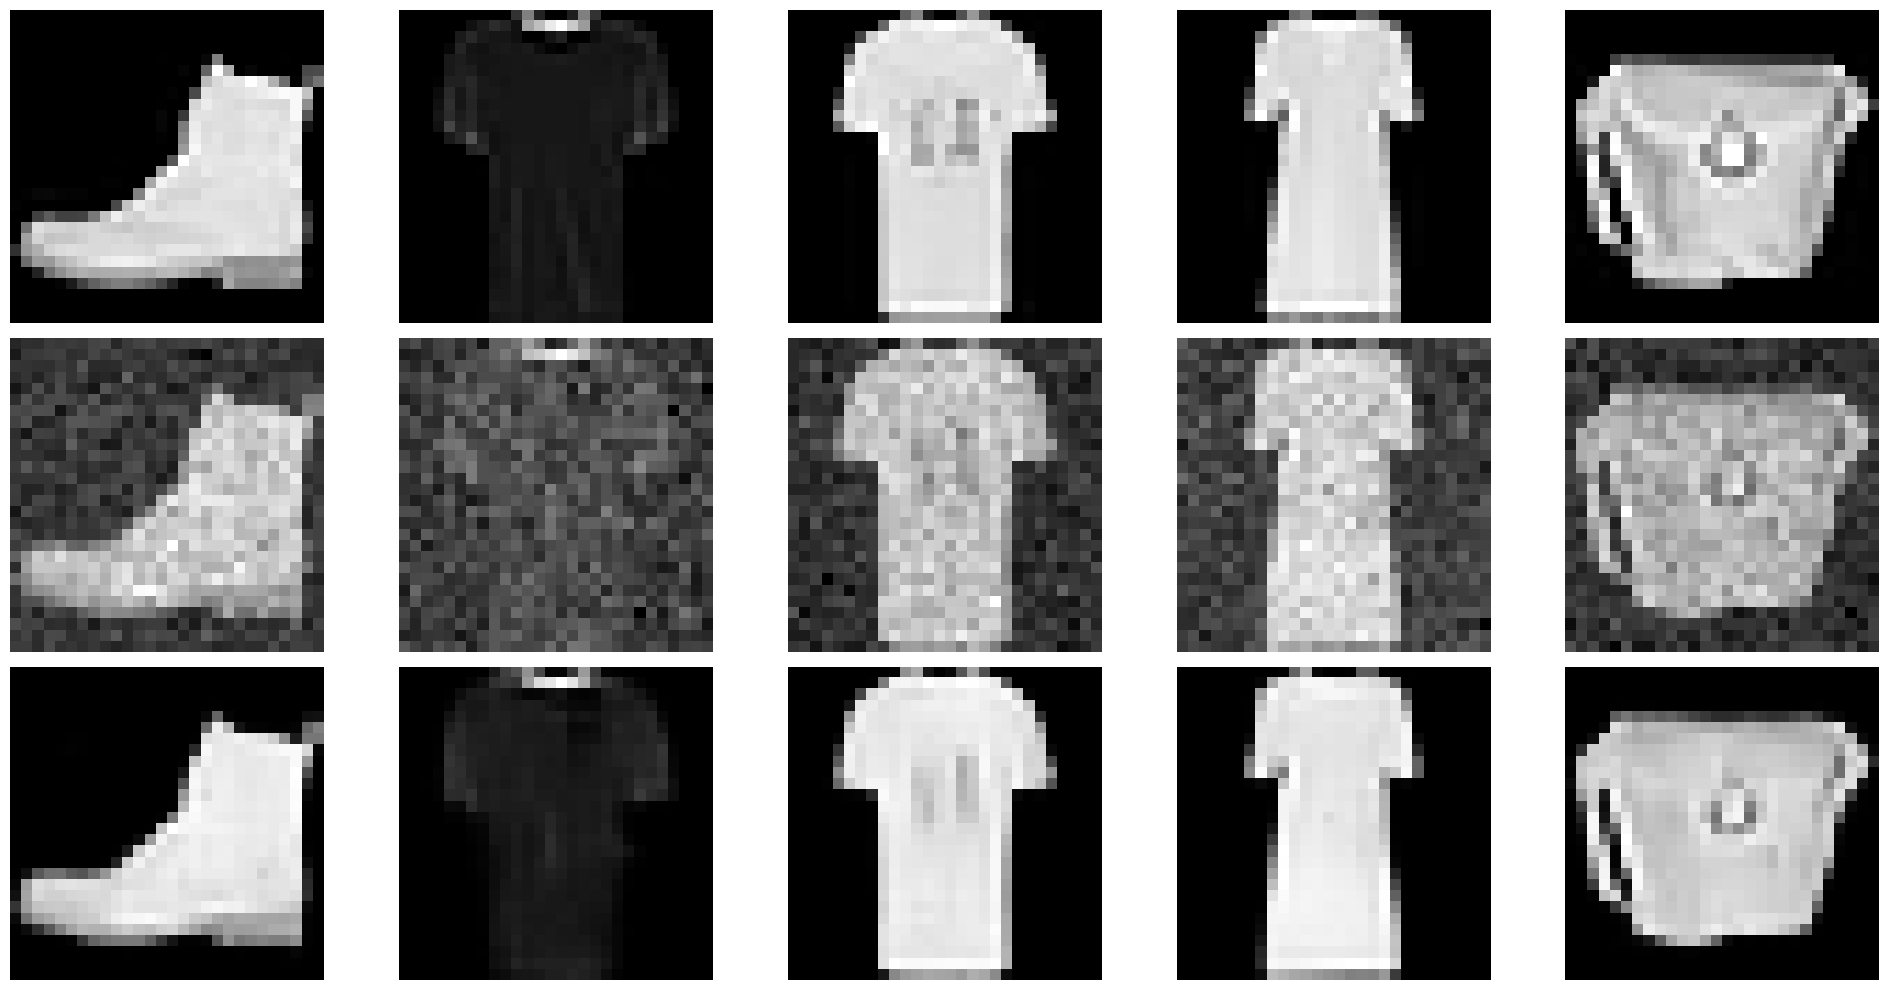

In [49]:
visualize_denoising_examples(amount=5, model=model_denoise_deeper, dataset=train_dataset_noisy)

### Observation
Loss and scores seem to improve! <br>
Improvements are swifter


## Experiment 3: Batch Norm

### For Classification Model

In [50]:
class Net_BatchNorm(nn.Module):
    def __init__(self):
        super(Net_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [51]:
model_batchnorm = Net_BatchNorm().to(device)
optimizer_batchnorm = torch.optim.Adam(model_batchnorm.parameters(), lr=0.001)
scheduler_batchnorm = torch.optim.lr_scheduler.StepLR(optimizer_batchnorm, step_size=5, gamma=0.1)

for epoch in range(1, 11):
    train(model_batchnorm, device, train_loader_classification, optimizer_batchnorm, loss_fn_classification, epoch)
    test(model_batchnorm, device, test_loader_classification, loss_fn_classification)
    scheduler_batchnorm.step()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 24.988079
Test set: Average loss: 0.3646, Accuracy: 8681/10000 (87%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 20.023106
Test set: Average loss: 0.2985, Accuracy: 8864/10000 (89%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 25.857758
Test set: Average loss: 0.2614, Accuracy: 9021/10000 (90%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 25.946569
Test set: Average loss: 0.2493, Accuracy: 9123/10000 (91%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 13.029613
Test set: Average loss: 0.2443, Accuracy: 9117/10000 (91%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 19.967102
Test set: Average loss: 0.2223, Accuracy: 9203/10000 (92%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 14.323973
Test set: Average loss: 0.2175, Accuracy: 9211/10000 (92%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 11.869120
Test set: Average loss: 0.2163, Accuracy: 9224/10000 (92%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 15.980146
Test set: Average loss: 0.2184, Accuracy: 9229/10000 (92%)
Train Epoc

In [52]:
true_positive = torch.zeros(10)     # TP
true_negative = torch.zeros(10)     # TN
false_positive = torch.zeros(10)    # FP
false_negative = torch.zeros(10)    # FN 

model_batchnorm.eval()
model_batchnorm.to(device)
for data, target in test_dataset:
    data = data.to(device)
    out = model_batchnorm(data.unsqueeze(0))
    pred = out.argmax(dim=1, keepdims= True)
    if pred == target:
        true_positive[target] += 1          # TP
        # True Negatives
        for i in range(10):
            if i != target:
                true_negative[i] += 1       # TN
    else:
        false_negative[target] += 1         # FN
        false_positive[pred.to("cpu")] += 1 # FP

# Accuracy: correct classifications/total classifications   OR  (TP+TN)/(TP+TN+FP+FN) 
accuracy_matrix_batchnorm = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Precision:  correct actual positives/ everthing classified as positive:  TP/(TP+FP)
precision_matrix_batchnorm = true_positive/(true_positive + false_positive)

# Recall: correct actual positives/ all actual positives : TP/(TP+FN)
recall_matric_batchnorm = true_positive/(true_positive + false_negative)

# F1 Score: 2* (Precision*Recall)/(Precision+Recall)   OR  # 2*TP/(2*TP + FP + FN)
f1_matrix_batchnorm = 2 * true_positive / (2*true_positive + false_positive + false_negative)
f1_matrix_2_batchnorm = 2* (precision_matrix_batchnorm * recall_matric_batchnorm) / (precision_matrix_batchnorm + recall_matric_batchnorm)

for i in range(10):
    print(idx_to_class[i])
    print(f"  Accuracy for: {round(float(accuracy_matrix_batchnorm[i]*100), 2)}%")
    print(f"  Precision for: {round(float(precision_matrix_batchnorm[i]*100), 2)}%")
    print(f"  Recall for: {round(float(recall_matric_batchnorm[i]*100), 2)}%")
    print(f"  F1 Score: {round(float(f1_matrix_batchnorm[i]*100), 2)}%\n")
    # print(f"F1 Score : {f1_matrix_2[i]}%")

T-shirt/top
  Accuracy for: 97.38%
  Precision for: 86.94%
  Recall for: 88.5%
  F1 Score: 87.71%

Trouser
  Accuracy for: 99.74%
  Precision for: 99.49%
  Recall for: 98.1%
  F1 Score: 98.79%

Pullover
  Accuracy for: 97.39%
  Precision for: 87.02%
  Recall for: 88.5%
  F1 Score: 87.75%

Dress
  Accuracy for: 98.4%
  Precision for: 92.25%
  Recall for: 92.8%
  F1 Score: 92.52%

Coat
  Accuracy for: 97.51%
  Precision for: 88.35%
  Recall for: 88.0%
  F1 Score: 88.18%

Sandal
  Accuracy for: 99.73%
  Precision for: 98.7%
  Recall for: 98.8%
  F1 Score: 98.75%

Shirt
  Accuracy for: 95.26%
  Precision for: 77.97%
  Recall for: 75.4%
  F1 Score: 76.66%

Sneaker
  Accuracy for: 99.31%
  Precision for: 96.15%
  Recall for: 97.5%
  F1 Score: 96.82%

Bag
  Accuracy for: 99.68%
  Precision for: 98.4%
  Recall for: 98.6%
  F1 Score: 98.5%

Ankle boot
  Accuracy for: 99.41%
  Precision for: 97.58%
  Recall for: 96.9%
  F1 Score: 97.24%



### For Denoising Model

In [53]:
class DenoisingNet_BatchNorm(nn.Module):
    def __init__(self):
        super(DenoisingNet_BatchNorm, self).__init__()
        # Encoder (Down)
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)  # Output: [32, 28, 28]
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)  # Output: [64, 28, 28]
        self.bn2 = nn.BatchNorm2d(64)

        # Decoder (Up)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # Output: [32, 28, 28]
        self.bn3 = nn.BatchNorm2d(32)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1)  # Output: [1, 28, 28]

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.bn1(x)
        # print(f"After conv1: {x.shape}")
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        # print(f"After conv2: {x.shape}")
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print(f"After max_pool2d: {x.shape}")
        # x = self.dropout1(x)

        # Decoder
        x = self.deconv1(x)
        x = self.bn3(x)
        # print(f"After deconv1: {x.shape}")
        x = F.relu(x)
        x = self.deconv2(x)
        # print(f"After deconv2: {x.shape}")
        output = torch.sigmoid(x)  # For pixel values in [0, 1]
        return output

In [54]:
model_denoise_batchnorm = DenoisingNet_BatchNorm().to(device)
optimizer_batchnorm = torch.optim.Adam(model_denoise_batchnorm.parameters(), lr=0.001)

for epoch in range(1, 11):
    train(model_denoise_batchnorm, device, train_loader_denoise, optimizer_batchnorm, loss_fn_denoise, epoch)
    print("\n")
    # test(model_denoise, device, test_loader_denoise, loss_fn)

Train Epoch: 1 [59520/60000 (99%)]	Loss: 146.699600

Train Epoch: 2 [59520/60000 (99%)]	Loss: 130.214203

Train Epoch: 3 [59520/60000 (99%)]	Loss: 130.265930

Train Epoch: 4 [59520/60000 (99%)]	Loss: 123.061531

Train Epoch: 5 [59520/60000 (99%)]	Loss: 114.033066

Train Epoch: 6 [59520/60000 (99%)]	Loss: 123.220901

Train Epoch: 7 [59520/60000 (99%)]	Loss: 117.696922

Train Epoch: 8 [59520/60000 (99%)]	Loss: 108.866714

Train Epoch: 9 [59520/60000 (99%)]	Loss: 107.300400

Train Epoch: 10 [59520/60000 (99%)]	Loss: 105.133728



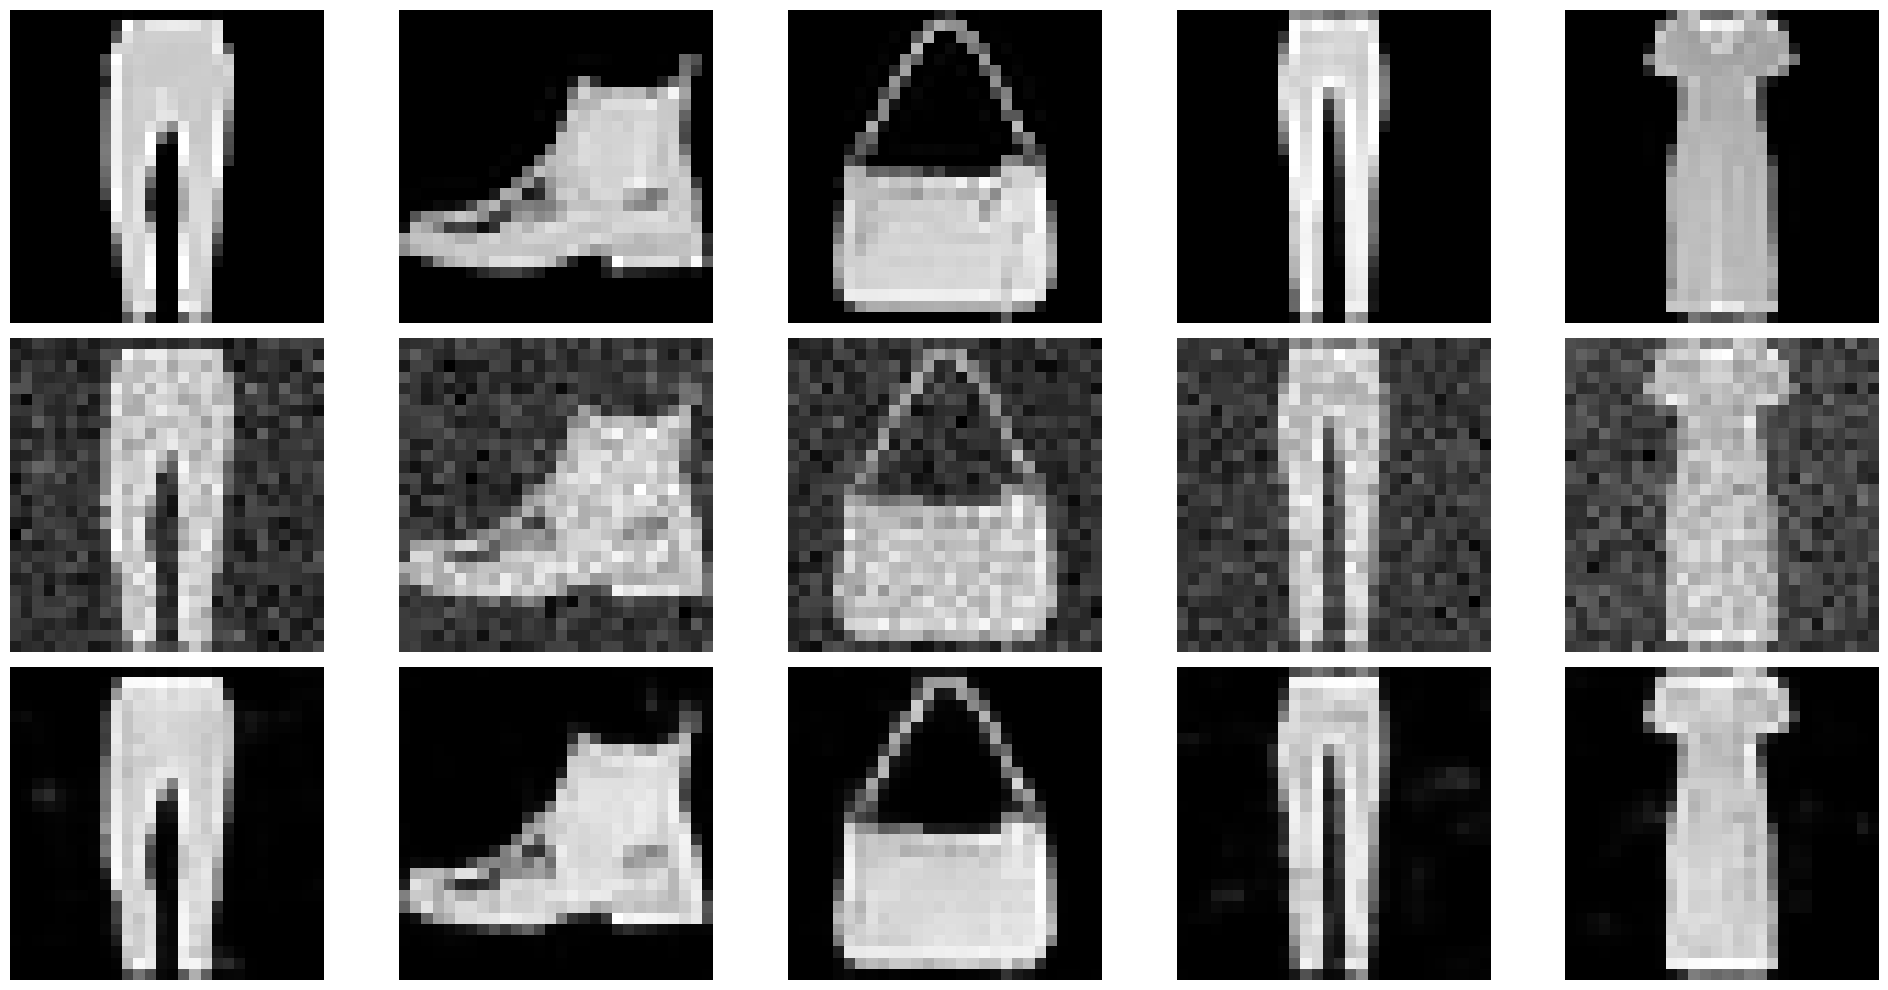

In [55]:
visualize_denoising_examples(amount=5, model=model_denoise_batchnorm, dataset=train_dataset_noisy)

### Observation

Moderate improvements in results

## Summary

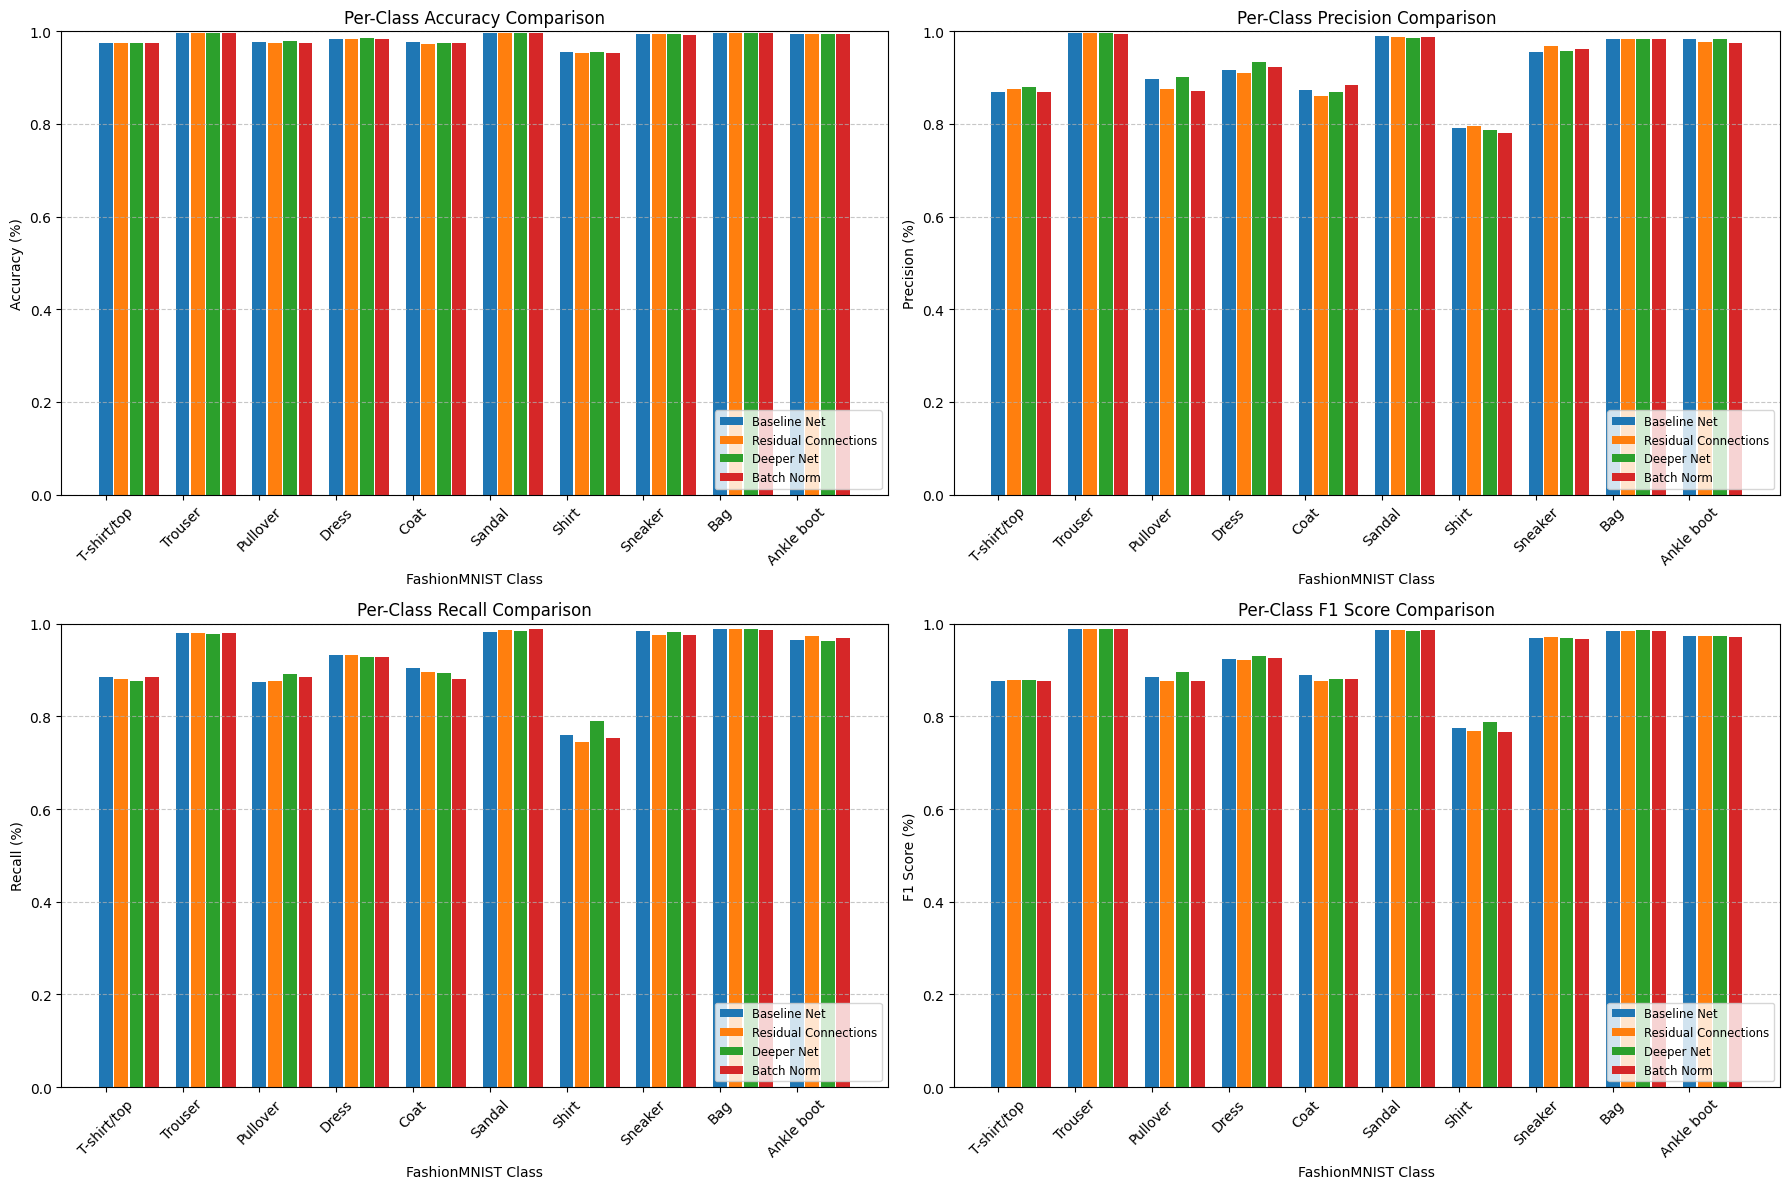

In [63]:
metrics_data = {
    "Accuracy": {
        "Baseline Net": accuracy_matrix,
        "Residual Connections": accuracy_matrix_skipconn,
        "Deeper Net": accuracy_matrix_deeper,
        "Batch Norm": accuracy_matrix_batchnorm,
    },
    "Precision": {
        "Baseline Net": precision_matrix,
        "Residual Connections": precision_matrix_skipconn,
        "Deeper Net": precision_matrix_deeper,
        "Batch Norm": precision_matrix_batchnorm,
    },
    "Recall": {
        "Baseline Net": recall_matric,
        "Residual Connections": recall_matric_skipconn,
        "Deeper Net": recall_matric_deeper,
        "Batch Norm": recall_matric_batchnorm,
    },
    "F1 Score": {
        "Baseline Net": f1_matrix,
        "Residual Connections": f1_matrix_skipconn,
        "Deeper Net": f1_matrix_deeper,
        "Batch Norm": f1_matrix_batchnorm,
    },
}
num_classes = 10
bar_width = 0.18
spacing = 0.02
index = np.arange(num_classes)

plt.figure(figsize=(18, 12)) 

for i, (metric_name, models_data) in enumerate(metrics_data.items()):
    plt.subplot(2, 2, i + 1) 
    
    model_offset = 0
    for model_name, values in models_data.items():
        plt.bar(index + model_offset, values, bar_width, label=model_name)
        model_offset += bar_width + spacing

    plt.xlabel("FashionMNIST Class")
    plt.ylabel(f"{metric_name} (%)")
    plt.title(f"Per-Class {metric_name} Comparison")
    plt.xticks(range(10), [idx_to_class[i] for i in range(10)], rotation=45)
    plt.ylim(0, 1) 
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [57]:
def visualize_denoising_summary_compare(amount, models_dict, dataset=None):
    indices = random.sample(range(len(dataset)), amount)

    noisy_images, original_images = zip(*[dataset[idx] for idx in indices])
    
    # Total rows
    total_rows = 2 + len(models_dict)
    
    plt.figure(figsize=(20, total_rows * 3)) # Adjust figure height based on number of models

    # Plot Original images (Row 1)
    for i in range(amount):
        plt.subplot(total_rows, amount, i + 1)
        plt.imshow(original_images[i].squeeze().cpu().numpy(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=14)

    # Plot Noisy images (Row 2)
    for i in range(amount):
        plt.subplot(total_rows, amount, amount + i + 1)
        plt.imshow(noisy_images[i].squeeze().cpu().numpy(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Noisy", fontsize=14)

    # Plot Denoised images for each model
    row_offset = 2 * amount
    with torch.no_grad():
        for model_name, model in models_dict.items():
            model.eval()

            denoised_images_model = [model(noisy_img.unsqueeze(0).to(device)).squeeze().cpu().numpy() for noisy_img in noisy_images]

            for i in range(amount):
                plt.subplot(total_rows, amount, row_offset + i + 1)
                plt.imshow(denoised_images_model[i], cmap="gray")
                plt.axis("off")
                if i == 0:
                    plt.ylabel(f"Denoised by {model_name}", fontsize=14)
            
            row_offset += amount # Move to the next row for the next model

    plt.tight_layout()
    plt.show()

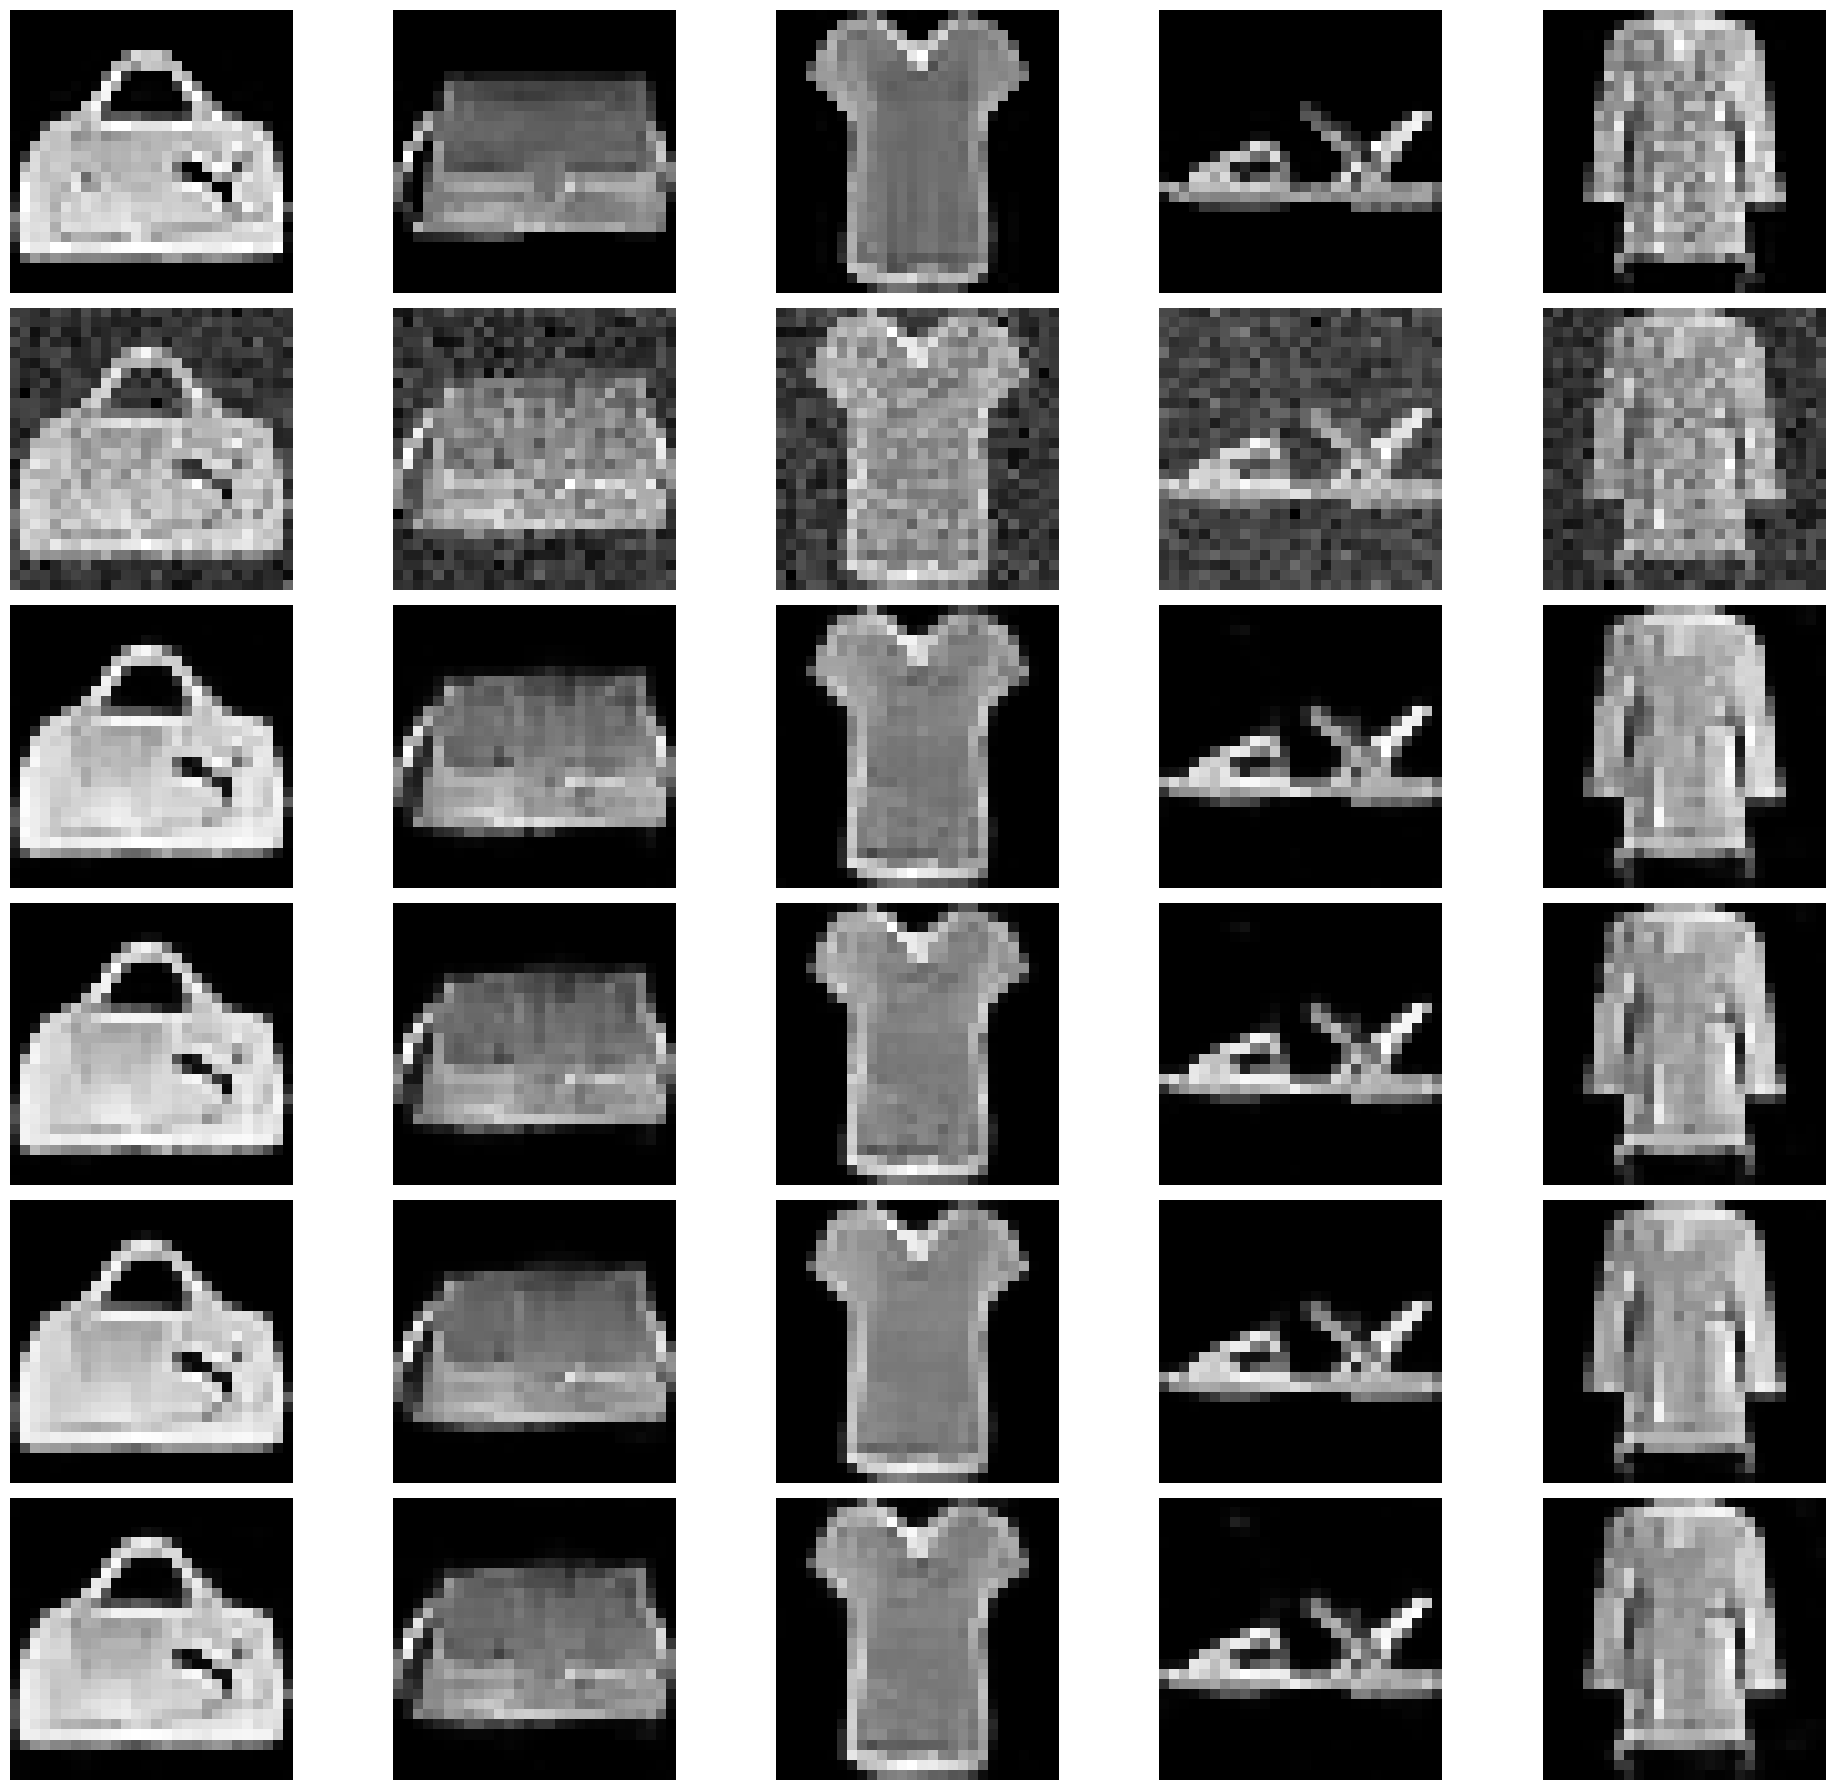

In [58]:
models_to_compare = {
    "Baseline": model_denoise,
    "Residual Connections": model_denoise_skipcon,
    "Deeper Net": model_denoise_deeper,
    "Batch Norm": model_denoise_batchnorm,
}

visualize_denoising_summary_compare(amount=5, models_dict=models_to_compare, dataset=train_dataset_noisy)